# 1 数据集准备
这次，我们使用一个新的数据集：手写数字图像识别。
你可能之前已经知道这个数据集了，它并不需要我们和之前一样在网上寻找数据集下载。
pytorch内置了这个经典数据集的下载链接，我们可以直接通过API下载它到项目目录：

In [8]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader  
from torch.nn import init  
import matplotlib.pyplot as plt  
  
transform = transforms.Compose([  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])  
# 载入训练数据集  
train_dataset = datasets.MNIST(  
    root='./data',  
    train=True,  
    download=True,  
    transform=transform  
)  
test_dataset = datasets.MNIST(  
    root='./data',  
    train=False,  
    download=True,  
    transform=transform  
) 

这是一个十分类数据集，包含七万张手写数字图像。可以以此对手写数字的图像进行分类，如果训练的模型较为成功，那么我们就可以得到一个可以识别手写数字的分类器。

<p align="center">
  <img src="https://penry-1352739541.cos.ap-beijing.myqcloud.com/img/20251215190952069.png" alt="" width="55%" height="height">
</p>

# 2 网络结构

根据我们在本周所了解的内容，再结合数据集的情况，我们设计新的网络结构如下：

In [9]:
class NeuralNetwork(nn.Module):  
    def __init__(self):  
        super(NeuralNetwork, self).__init__()  
        self.flatten = nn.Flatten()  
        self.hidden1 = nn.Linear(28 * 28, 512)  
        self.bn1 = nn.BatchNorm1d(512)  # 第一层的BN
        self.hidden2 = nn.Linear(512, 256)  
        self.bn2 = nn.BatchNorm1d(256)  # 第二层的BN
        self.hidden3 = nn.Linear(256, 128)  
        self.bn3 = nn.BatchNorm1d(128)  # 第三层的BN
        self.hidden4 = nn.Linear(128, 32)  
        self.bn4 = nn.BatchNorm1d(32)  # 第四层的BN
        self.relu = nn.ReLU()  
        self.output = nn.Linear(32, 10)  
        self.softmax = nn.Softmax(dim=1)  
        init.xavier_uniform_(self.output.weight)  
    # 把BN加入传播过程
    def forward(self, x):  
        x = self.flatten(x)  
        x = self.hidden1(x)  
        x = self.bn1(x)  # 这里 
        x = self.relu(x)  
        x = self.hidden2(x)  
        x = self.bn2(x)  # 这里
        x = self.relu(x)  
        x = self.hidden3(x)  
        x = self.bn3(x)  # 这里
        x = self.relu(x)  
        x = self.hidden4(x)  
        x = self.bn4(x)  # 这里
        x = self.relu(x)  
        x = self.output(x)  
        x = self.softmax(x)  
        return x


# 3 损失函数和其他设置

In [10]:
# 迭代设置
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# 图像较简单，因此增加批次大小到64

# 损失函数和优化器  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model = NeuralNetwork().to(device)  

# 训练设置  
criterion = nn.CrossEntropyLoss()  # 多分类使用交叉熵损失 
optimizer = optim.Adam(model.parameters(), lr=0.001) # 优化器默认选择Adam
num_epochs = 10 # 训练十轮

train_losses, train_accuracies, test_accuracies = [], [], []  

# 4 训练和测试

In [11]:
# 训练  
for epoch in range(num_epochs):  
    model.train()  
    running_loss = 0.0  
    correct_train = 0  
    total_train = 0  
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item() * images.size(0)  
        _, predicted = torch.max(outputs, 1)  
        total_train += labels.size(0)  
        correct_train += (predicted == labels).sum().item()  
  
    epoch_loss = running_loss / len(train_loader.dataset)  
    train_accuracy = correct_train / total_train  
    train_losses.append(epoch_loss)  
    train_accuracies.append(train_accuracy)  
  
    # 测试  
    model.eval()  
    correct_test = 0  
    total_test = 0  
    with torch.no_grad():  
        for images, labels in test_loader:  
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, predicted = torch.max(outputs, 1)  
            total_test += labels.size(0)  
            correct_test += (predicted == labels).sum().item()  
    test_accuracy = correct_test / total_test  
    test_accuracies.append(test_accuracy)  
  
    print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | "          f"Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")  

Epoch 1/10 | Loss: 1.5602 | Train Acc: 0.9279 | Test Acc: 0.9612
Epoch 2/10 | Loss: 1.5044 | Train Acc: 0.9598 | Test Acc: 0.9675
Epoch 3/10 | Loss: 1.4952 | Train Acc: 0.9681 | Test Acc: 0.9716
Epoch 4/10 | Loss: 1.4913 | Train Acc: 0.9715 | Test Acc: 0.9766
Epoch 5/10 | Loss: 1.4866 | Train Acc: 0.9755 | Test Acc: 0.9765
Epoch 6/10 | Loss: 1.4845 | Train Acc: 0.9775 | Test Acc: 0.9790
Epoch 7/10 | Loss: 1.4823 | Train Acc: 0.9797 | Test Acc: 0.9777
Epoch 8/10 | Loss: 1.4816 | Train Acc: 0.9801 | Test Acc: 0.9762
Epoch 9/10 | Loss: 1.4806 | Train Acc: 0.9811 | Test Acc: 0.9772
Epoch 10/10 | Loss: 1.4781 | Train Acc: 0.9835 | Test Acc: 0.9811


# 5 可视化

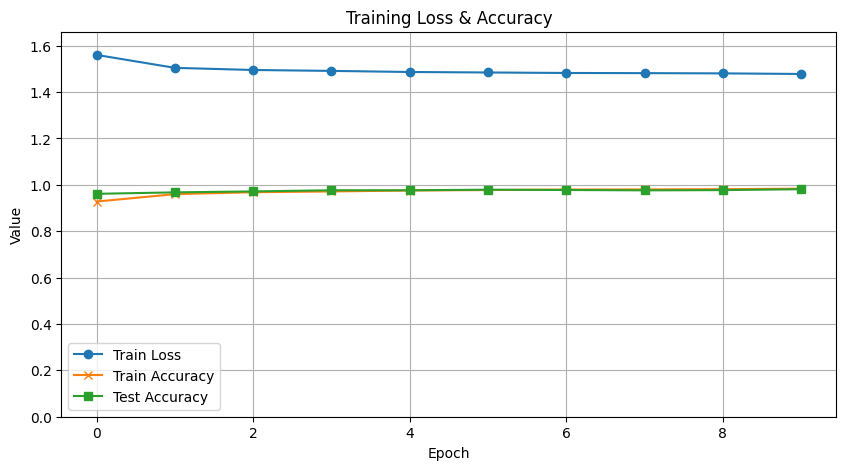

In [12]:
# 可视化  
plt.figure(figsize=(10, 5))  
plt.plot(train_losses, label='Train Loss', marker='o')  
plt.plot(train_accuracies, label='Train Accuracy', marker='x')  
plt.plot(test_accuracies, label='Test Accuracy', marker='s')  
plt.title('Training Loss & Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Value')  
plt.ylim(0, max(max(train_losses), 1.0) + 0.1)  
plt.grid(True)  
plt.legend()  
plt.show()